In [1]:
import pandas as pd
import numpy as np
import nltk
import huggingface_hub
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download('omw-1.4')
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()
from bertopic import BERTopic
from umap import UMAP
import re as re
import os 
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from umap import UMAP

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/silvinhad/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/silvinhad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('/Users/silvinhad/Desktop/bertopic Python Analysis/amandaklein_tweets.csv').astype("string")
data = data.dropna(subset=["text"])
data.head(3)

,id,author_id,text,edit_history_tweet_ids,possibly_sensitive,in_reply_to_user_id,created_at,referenced_tweets,conversation_id,lang,retweet_count,reply_count,like_count,quote_count
0,1586860768519135234,2466911024,@JovemPanNews A parcialidade de vocês me faz n...,<NA>,False,106175018.0,2022-10-30T23:21:04.000Z,<NA>,1586855631922909185,pt,0,0,2,0
1,1586813481021571075,305352481,@JoaoGSiilva @DaniAlvesD2 A federal pegos a pe...,<NA>,False,39920309.0,2022-10-30T20:13:10.000Z,<NA>,1586773724031754243,pt,0,0,0,0
2,1586810950224691207,9921902,A jovem pan já pode mandar embora a Amanda Kle...,<NA>,False,<NA>,2022-10-30T20:03:06.000Z,<NA>,1586810950224691207,pt,0,0,0,0


In [3]:
data_sample = data.sample(n=30000, random_state=42).reset_index(drop=True)

In [4]:
import re as re
import unicodedata as unicodedata
def basic_clean(string):
    '''
    This function takes in a string and
    returns the string normalized.
    '''
    string = str(string)
    string = string.lower()
    string = re.sub(r'#[A-Za-z0-9]*', ' ', string)
    string = re.sub(r'@[A-Za-z0-9]+', ' ', string)
    string = re.sub(r'[%s]' % re.escape('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~“…”’'), ' ', string)
    string = re.sub(r'\d+', ' ', string)
    string = re.sub(r'\n+', ' ', string)
    string = re.sub(r"http\S+", "", string)   # URLs
    string = re.sub(r"@\w+", "", string)      # mentions
    string = re.sub(r"\s+", " ", string)
    string = unicodedata.normalize('NFKD', string)\
             .encode('ascii', 'ignore')\
             .decode('utf-8', 'ignore')
    string = re.sub(r'[^\w\s]', '', string).lower()
    return string

data_sample['basic_clean'] = data_sample.text.apply(basic_clean).astype("string")
data_sample['basic_clean']

0         amanda klein tem razao qdo disse q so a elite...
1        rt amanda klein esta tendo seus minutos de ver...
2        rt  na jovem pan amanda klein diz que ciro e i...
3        rt amanda klein acaba de dizer q o mensalao e ...
4        rt amanda klein conseguiu agora ela passa verg...
                               ...                        
29995    rt nosso presidente simplesmente deu show na s...
29996    rt dudasc vozes que me causam nauseas e embrul...
29997    rt a noticia nao e o marido da amanda klein pa...
29998    rt sem resposta para origem do dinheiro vivo q...
29999     bolsonaro usa a velha tatica de sempre quando...
Name: basic_clean, Length: 30000, dtype: string

In [5]:
def tokenize(string):
    '''
    This function takes in a string and
    returns a tokenized string.
    '''
    # Create tokenizer.
    tokenizer = nltk.tokenize.ToktokTokenizer()

    # Use tokenizer
    string = tokenizer.tokenize(string, return_str = True)

    return string

data_sample['tokenize'] = data_sample.basic_clean.apply(tokenize).astype("string")
data_sample['tokenize']

0        amanda klein tem razao qdo disse q so a elite ...
1        rt amanda klein esta tendo seus minutos de ver...
2        rt na jovem pan amanda klein diz que ciro e in...
3        rt amanda klein acaba de dizer q o mensalao e ...
4        rt amanda klein conseguiu agora ela passa verg...
                               ...                        
29995    rt nosso presidente simplesmente deu show na s...
29996    rt dudasc vozes que me causam nauseas e embrul...
29997    rt a noticia nao e o marido da amanda klein pa...
29998    rt sem resposta para origem do dinheiro vivo q...
29999    bolsonaro usa a velha tatica de sempre quando ...
Name: tokenize, Length: 30000, dtype: string

In [6]:
def lemmatize(string):
    '''
    This function takes in string for and
    returns a string with words lemmatized.
    '''
    # Create the lemmatizer.
    wnl = nltk.stem.WordNetLemmatizer()

    # Use the lemmatizer on each word in the list of words we created by using split.
    lemmas = [wnl.lemmatize(word) for word in string.split()]

    # Join our list of words into a string again and assign to a variable.
    string = ' '.join(lemmas)
    
    return string

data_sample['lemmatize'] = data_sample.tokenize.apply(lemmatize).astype("string")
data_sample['lemmatize']

0        amanda klein tem razao qdo disse q so a elite ...
1        rt amanda klein esta tendo seus minutos de ver...
2        rt na jovem pan amanda klein diz que ciro e in...
3        rt amanda klein acaba de dizer q o mensalao e ...
4        rt amanda klein conseguiu agora ela passa verg...
                               ...                        
29995    rt nosso presidente simplesmente deu show na s...
29996    rt dudasc vozes que me causam nausea e embrulh...
29997    rt a noticia nao e o marido da amanda klein pa...
29998    rt sem resposta para origem do dinheiro vivo q...
29999    bolsonaro usa a velha tatica de sempre quando ...
Name: lemmatize, Length: 30000, dtype: string

In [7]:
import pandas as pd

stopwords = pd.read_csv('/Users/silvinhad/Desktop/bertopic Python Analysis/Portuguese_stopwords.csv', header=None) [0].tolist()

print(len(stopwords))   # should be 432
print(stopwords[:10])   # preview

433
['word', '4k3oos92am', 'a', 'à', 'afirma', 'afirmou', 'agora', 'aí', 'ainda', 'além']


In [8]:
def remove_stopwords(string, extra_words = [], exclude_words = []):
    '''
    This function takes in a string, optional extra_words and exclude_words parameters
    with default empty lists and returns a string.
    '''
    # Create stopword_list.
    stopword_list = stopwords
    
    # Remove 'exclude_words' from stopword_list to keep these in my text.
    stopword_list = set(stopword_list) - set(exclude_words)
    
    # Add in 'extra_words' to stopword_list.
    stopword_list = stopword_list.union(set(extra_words))

    # Split words in string.
    words = string.split()
    
    # Create a list of words from my string with stopwords removed and assign to variable.
    filtered_words = [word for word in words if word not in stopword_list]
    
    # Join words in the list back into strings and assign to a variable.
    string_without_stopwords = ' '.join(filtered_words)
    
    return string_without_stopwords

data_sample['text_without_stopwords'] = data_sample.lemmatize.apply(remove_stopwords).astype("string")
data_sample['text_without_stopwords']


0        amanda klein razao qdo q so elite banqueiros e...
1                      amanda klein minutos vera magalhaes
2        jovem pan amanda klein ciro inteligente articu...
3        amanda klein acaba q mensalao emendas relator ...
4        amanda klein conseguiu passa vergonha manha ta...
                               ...                        
29995    presidente simplesmente deu show sabatina pass...
29996    dudasc vozes causam nausea embrulham estomago ...
29997    noticia nao marido amanda klein parem noticia ...
29998    sem resposta origem dinheiro vivo familiares c...
29999    bolsonaro usa velha tatica sempre nao explicar...
Name: text_without_stopwords, Length: 30000, dtype: string

In [9]:
data_sample

,id,author_id,text,edit_history_tweet_ids,possibly_sensitive,in_reply_to_user_id,created_at,referenced_tweets,conversation_id,lang,retweet_count,reply_count,like_count,quote_count,basic_clean,tokenize,lemmatize,text_without_stopwords
0,1553894149379735553,66223821,@fabiunascimento Amanda Klein tem razão qdo di...,<NA>,False,46891874.0,2022-08-01T00:03:29.000Z,<NA>,1553553151533481991,pt,0,1,1,0,amanda klein tem razao qdo disse q so a elite...,amanda klein tem razao qdo disse q so a elite ...,amanda klein tem razao qdo disse q so a elite ...,amanda klein razao qdo q so elite banqueiros e...
1,1567178405287792641,1565083501929676806,RT @kimpaim: Amanda Klein está tendo seus 15 m...,<NA>,False,<NA>,2022-09-06T15:50:23.000Z,<NA>,1567178405287792641,pt,1947,0,0,0,rt amanda klein esta tendo seus minutos de ver...,rt amanda klein esta tendo seus minutos de ver...,rt amanda klein esta tendo seus minutos de ver...,amanda klein minutos vera magalhaes
2,1554188326458081280,4927749689,"RT @APrimeiraVia: 🚨 Na Jovem Pan, Amanda Klein...",<NA>,False,<NA>,2022-08-01T19:32:27.000Z,<NA>,1554188326458081280,pt,317,0,0,0,rt na jovem pan amanda klein diz que ciro e i...,rt na jovem pan amanda klein diz que ciro e in...,rt na jovem pan amanda klein diz que ciro e in...,jovem pan amanda klein ciro inteligente articu...
3,1563143823710072835,1008033175849897984,RT @saritacoelho: Amanda Klein acaba de dizer ...,<NA>,False,<NA>,2022-08-26T12:38:24.000Z,<NA>,1563143823710072835,pt,1137,0,0,0,rt amanda klein acaba de dizer q o mensalao e ...,rt amanda klein acaba de dizer q o mensalao e ...,rt amanda klein acaba de dizer q o mensalao e ...,amanda klein acaba q mensalao emendas relator ...
4,1567146542020104194,1519136899008450560,RT @domlancellotti: AMANDA KLEIN CONSEGUIU!\n\...,<NA>,False,<NA>,2022-09-06T13:43:46.000Z,<NA>,1567146542020104194,pt,173,0,0,0,rt amanda klein conseguiu agora ela passa verg...,rt amanda klein conseguiu agora ela passa verg...,rt amanda klein conseguiu agora ela passa verg...,amanda klein conseguiu passa vergonha manha ta...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1567143165727047680,1257834846879207424,RT @MarPetrucelli: Nosso presidente @jairbolso...,<NA>,False,<NA>,2022-09-06T13:30:21.000Z,<NA>,1567143165727047680,pt,626,0,0,0,rt nosso presidente simplesmente deu show na s...,rt nosso presidente simplesmente deu show na s...,rt nosso presidente simplesmente deu show na s...,presidente simplesmente deu show sabatina pass...
29996,1582698983352246272,1035227535553056768,RT @__dudasc: Vozes que me causam náuseas e em...,<NA>,False,<NA>,2022-10-19T11:43:37.000Z,<NA>,1582698983352246272,pt,3116,0,0,0,rt dudasc vozes que me causam nauseas e embrul...,rt dudasc vozes que me causam nauseas e embrul...,rt dudasc vozes que me causam nausea e embrulh...,dudasc vozes causam nausea embrulham estomago ...
29997,1567511846046892035,765948824,RT @RitaLisauskas: A notícia não é o marido da...,<NA>,False,<NA>,2022-09-07T13:55:21.000Z,<NA>,1567511846046892035,pt,1384,0,0,0,rt a noticia nao e o marido da amanda klein pa...,rt a noticia nao e o marido da amanda klein pa...,rt a noticia nao e o marido da amanda klein pa...,noticia nao marido amanda klein parem noticia ...
29998,1567128596166152197,1494425697867247618,RT @KennedyAlencar: Sem resposta para origem d...,<NA>,False,<NA>,2022-09-06T12:32:27.000Z,<NA>,1567128596166152197,pt,1059,0,0,0,rt sem resposta para origem do dinheiro vivo q...,rt sem resposta para origem do dinheiro vivo q...,rt sem resposta para origem do dinheiro vivo q...,sem resposta origem dinheiro vivo familiares c...


In [10]:
# exporting the cleaned tweets to generate a wordcloud (part 2)
data_sample.text_without_stopwords.to_csv(r'tweets_sample_amandaklein_cleaned.csv', index=False)

In [11]:
import os
import pandas as pd

from umap import UMAP
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from gensim import corpora
from gensim.models import CoherenceModel

from bertopic import BERTopic
from hdbscan import HDBSCAN


# ------------------------------------------------------------------
# ENV
# ------------------------------------------------------------------
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ------------------------------------------------------------------
# EMBEDDINGS (pt-BR)
# ------------------------------------------------------------------

from transformers import AutoModel, AutoTokenizer

model_name = "neuralmind/bert-base-portuguese-cased"

# Load the tokenizer (handles text conversion)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the model (the actual BERT model)
model = AutoModel.from_pretrained(model_name)

embedding_model = SentenceTransformer(
    "neuralmind/bert-base-portuguese-cased"
)

# ------------------------------------------------------------------
# UMAP
# ------------------------------------------------------------------
umap_model = UMAP(
    n_neighbors=15,
    n_components=10,
    metric="cosine",
    low_memory=False,
    random_state=42
)

# ------------------------------------------------------------------
# VECTORIZER (n-grams)
# ------------------------------------------------------------------
vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),
    min_df=5
)

# ------------------------------------------------------------------
# BERTopic
# ------------------------------------------------------------------
hdbscan_model = HDBSCAN(
    min_cluster_size=30,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    embedding_model=embedding_model,
    nr_topics=60,
    calculate_probabilities=True,
    verbose=True
)

# ------------------------------------------------------------------
# FIT MODEL
# ------------------------------------------------------------------
docs = data_sample["text_without_stopwords"].tolist()
topics, _ = topic_model.fit_transform(docs)

# ------------------------------------------------------------------
# GROUP DOCUMENTS PER TOPIC (REMOVE OUTLIERS)
# ------------------------------------------------------------------
### WE NEED TO ADD THE NUMBER OF TWEETS PER TOPIC HERE!!!

documents = pd.DataFrame({
    "Document": docs,
    "Topic": topics
})

documents = documents[documents.Topic != -1]

documents_per_topic = (
    documents
    .groupby("Topic", as_index=False)
    .agg(
        tweets_count=("Document", "count"),
        Document=("Document", " ".join)
    )
)

No sentence-transformers model found with name neuralmind/bert-base-portuguese-cased. Creating a new one with MEAN pooling.
2026-01-13 00:05:34,926 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

2026-01-13 00:07:57,387 - BERTopic - Embedding - Completed ✓
2026-01-13 00:07:57,388 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2026-01-13 00:09:05,175 - BERTopic - Dimensionality - Completed ✓
2026-01-13 00:09:05,178 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-13 00:13:59,260 - BERTopic - Cluster - Completed ✓
2026-01-13 00:13:59,272 - BERTopic - Representation - Extracting topics from clusters using representation models.
2026-01-13 00:13:59,849 - BERTopic - Representation - Completed ✓
2026-01-13 00:13:59,849 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 00:14:00,351 - BERTopic - Topic reduction - Reduced number of topics from 408 to 60


In [12]:
# exporting document and topics
documents.to_csv(r'topics_tweets_amandaklein.csv',index=False)
documents_per_topic.to_csv(r'topics_grouped_amandaklein.csv', index=False)

In [13]:
documents_per_topic

,Topic,tweets_count,Document
0,0,4694,amanda klein razao qdo q so elite banqueiros e...
1,1,2950,amanda klein nao cansa passar vergonha aldo re...
2,2,2329,deltan dallagnol lapada epica amanda klein t p...
3,3,1627,amanda klein miriam leitao renata vasconcelos ...
4,4,1235,amanda klein defende voto pobres lula cala com...
5,5,1020,atencao amanda klein pergunta oposicao nao deb...
6,6,976,dudasc vozes causam nausea embrulham estomago ...
7,7,951,amanda klein minutos vera magalhaes amanda kle...
8,8,840,entrevista jovem pan bolsonaro agride jornalis...
9,9,492,bom amanda klein colher tudo plantou t azjp t ...


In [14]:

# ------------------------------------------------------------------
# TOKENIZATION (ALIGNED WITH VECTORIZER)
# ------------------------------------------------------------------
analyzer = vectorizer_model.build_analyzer()

tokens = [
    analyzer(doc)
    for doc in documents_per_topic.Document
]

# ------------------------------------------------------------------
# GENSIM STRUCTURES
# ------------------------------------------------------------------
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]

# ------------------------------------------------------------------
# EXTRACT & FILTER TOPIC WORDS (CRITICAL FIX)
# ------------------------------------------------------------------
topic_words = []

for topic in documents_per_topic.Topic:
    words = topic_model.get_topic(topic)
    if words is None:
        continue

    # keep only tokens known by gensim dictionary
    valid_words = [
        word for word, _ in words
        if word in dictionary.token2id
    ]

    # coherence requires at least 2 words
    if len(valid_words) >= 2:
        topic_words.append(valid_words)

# ------------------------------------------------------------------
# SAFETY CHECKS
# ------------------------------------------------------------------
assert len(topic_words) > 0, "No valid topics for coherence"
assert len(topic_words) <= len(tokens), "Topics/texts misalignment"

# ------------------------------------------------------------------
# COHERENCE
# ------------------------------------------------------------------
coherence_model = CoherenceModel(
    topics=topic_words,
    texts=tokens,
    corpus=corpus,
    dictionary=dictionary,
    coherence="c_v"
)

coherence = coherence_model.get_coherence()

print(f"Topic coherence (c_v): {coherence:.4f}")

Topic coherence (c_v): 0.4799


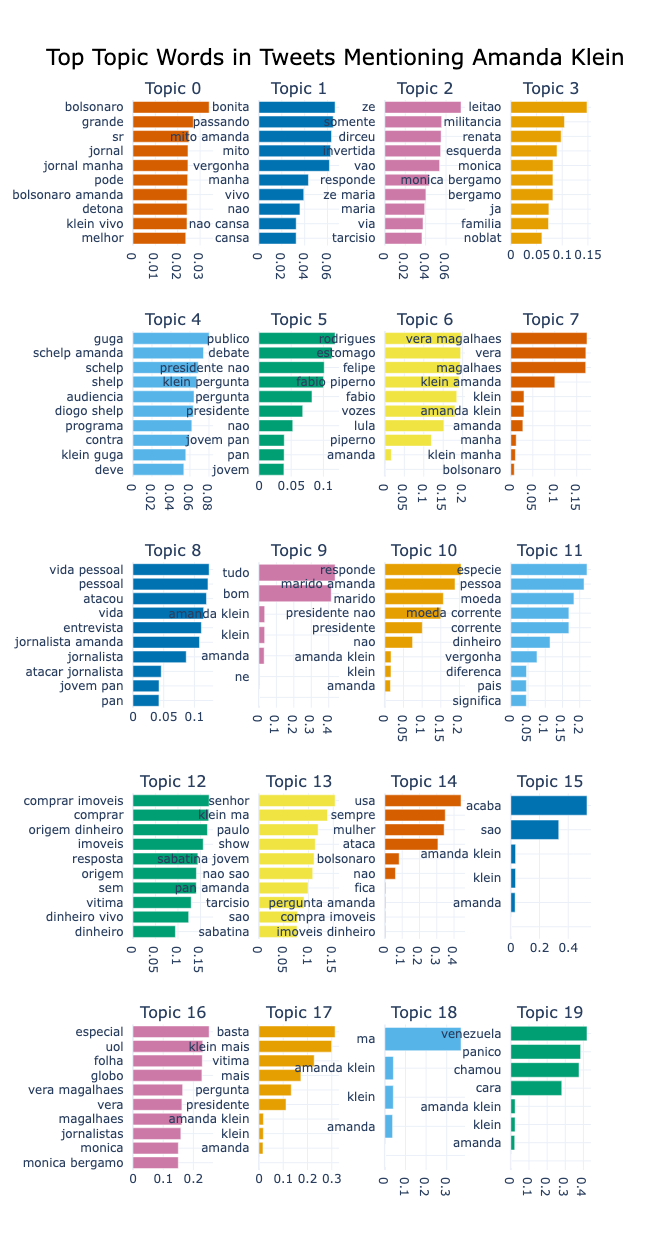

In [15]:
fig = topic_model.visualize_barchart(top_n_topics=20, n_words=10)

fig.update_layout(
    title_text="Top Topic Words in Tweets Mentioning Amanda Klein"
)

fig.show()

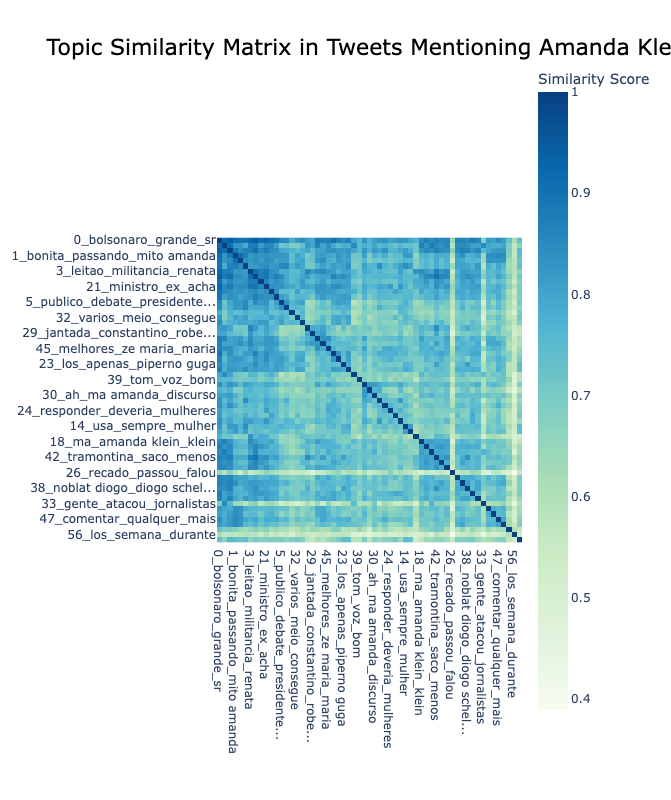

In [16]:
fig2 = topic_model.visualize_heatmap(n_clusters=20)

fig2.update_layout(
    title_text="Topic Similarity Matrix in Tweets Mentioning Amanda Klein"
)

fig2.show()

In [17]:
documents

,Document,Topic
0,amanda klein razao qdo q so elite banqueiros e...,0
1,amanda klein minutos vera magalhaes,7
2,jovem pan amanda klein ciro inteligente articu...,35
3,amanda klein acaba q mensalao emendas relator ...,15
4,amanda klein conseguiu passa vergonha manha ta...,46
...,...,...
29994,amanda klein recebe salario jp moeda corrente ...,20
29995,presidente simplesmente deu show sabatina pass...,26
29996,dudasc vozes causam nausea embrulham estomago ...,6
29997,noticia nao marido amanda klein parem noticia ...,10


In [18]:
import openai
from bertopic.representation import OpenAI
import os
os.environ["OPENAI_API_KEY"] = "ADD YOUR OPENAI KEY HERE" 

client = openai.OpenAI(api_key=os.environ["OPENAI_API_KEY"])

topic_model.update_topics(
    docs,
    topics=topics,
    representation_model=OpenAI(
        client,
        model="gpt-4o-mini",
        delay_in_seconds=5
    )
)
topic_model.get_topic_info()


2026-01-13 00:14:10,461 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
100%|███████████████████████████████████████████| 60/60 [05:40<00:00,  5.68s/it]


,Topic,Count,Name,Representation,Representative_Docs
0,-1,5871,-1_Brazilian political commentary,[Brazilian political commentary],"[amanda klein esplendor t v vn ff, cade amanda..."
1,0,4694,0_Political controversy surrounding Bolsonaro,[Political controversy surrounding Bolsonaro],[bolsonaro detona amanda klein vivo amanda sr ...
2,1,2950,1_Texto repetitivo e sem sentido,[Texto repetitivo e sem sentido],[mito amanda klein passando vergonha vivo core...
3,2,2329,2_Unintelligible or random text patterns,[Unintelligible or random text patterns],[vao restar somente amanda klein pipperno aspo...
4,3,1627,3_Political Militancy and Activism,[Political Militancy and Activism],[deonisio ja agradeco anita amanda klein miria...
5,4,1235,4_Political controversy in Brazil,[Political controversy in Brazil],[jovem pan deve programa diogo shelp amanda kl...
6,5,1020,5_Political discourse and media in Brazil,[Political discourse and media in Brazil],[atencao amanda klein pergunta oposicao nao de...
7,6,976,6_Confusing or incoherent statements in Portug...,[Confusing or incoherent statements in Portugu...,[dudasc vozes causam nausea embrulham estomago...
8,7,951,7_Personal conversations,[Personal conversations],"[amanda klein minutos vera magalhaes, amanda k..."
9,8,840,8_Controversial media interview with Bolsonaro,[Controversial media interview with Bolsonaro],[entrevista jovem pan bolsonaro agride jornali...


In [19]:
topic_info = topic_model.get_topic_info()

final_topics = topic_info.merge(
    documents_per_topic[["Topic", "tweets_count"]],
    on="Topic",
    how="left"
)

final_topics.to_csv(
    "bertopic_topics_openai_amandaklein.csv",
    index=False,
    encoding="utf-8"
)

In [20]:
import scipy.cluster.hierarchy as sch

linkage_function = lambda x: sch.linkage(
    x,
    method="single",
    optimal_ordering=True
)

hierarchical_topics = topic_model.hierarchical_topics(
    docs,
    linkage_function=linkage_function
)


100%|███████████████████████████████████████████| 58/58 [05:28<00:00,  5.66s/it]


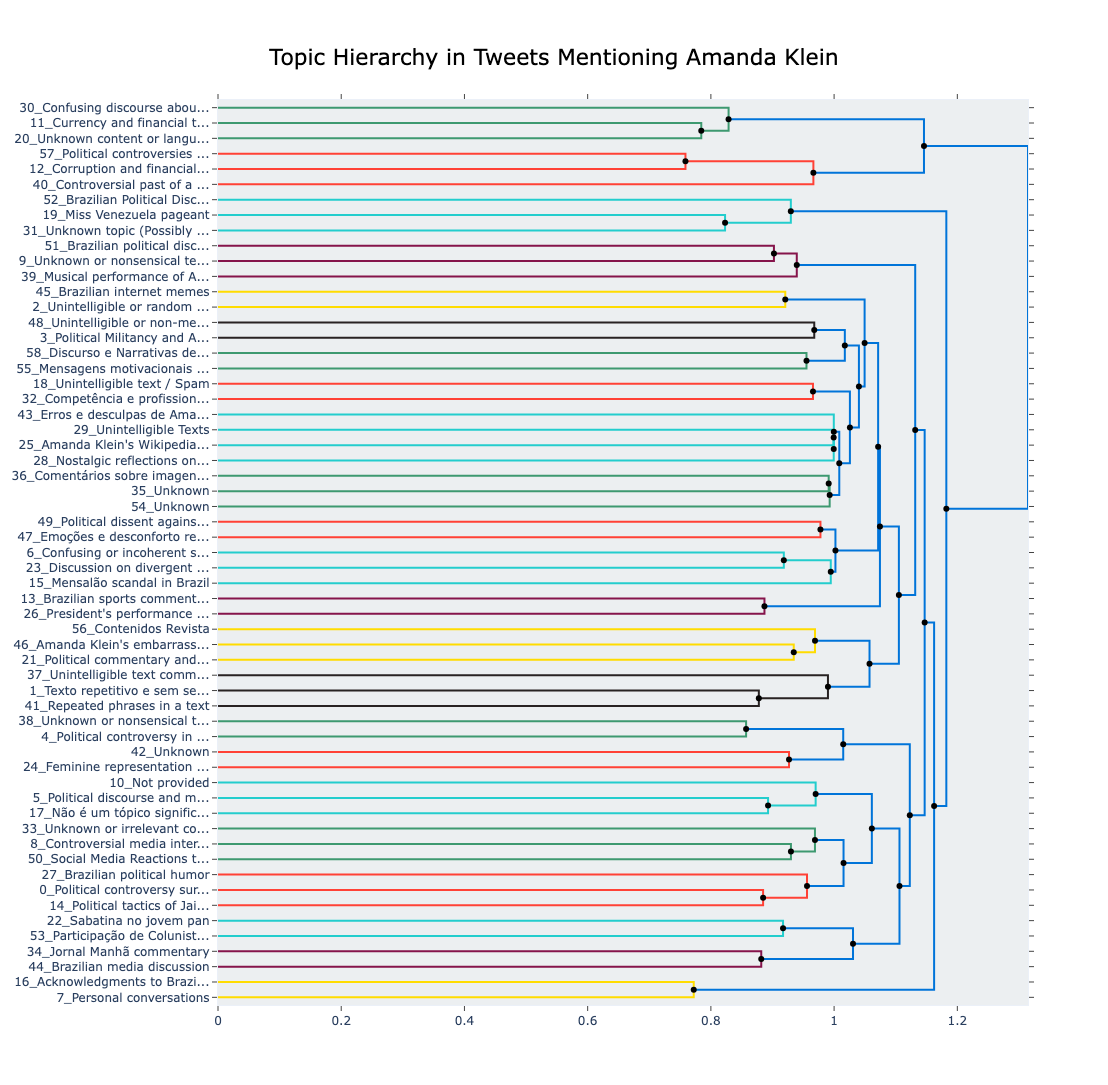

In [21]:
fig3 = topic_model.visualize_hierarchy(
    hierarchical_topics=hierarchical_topics
)

fig3.update_layout(
    title_text="Topic Hierarchy in Tweets Mentioning Amanda Klein"
)

fig3.show()


In [22]:
hierarchical_topics.to_csv(
    "hierarchical_topics_amandaklein.csv",
    index=False
)
